<a href="https://www.kaggle.com/code/mohammedmohsen0404/proj27-cv-aerial-semantic-segmentation-by-drone?scriptVersionId=194755279" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>Aerial Semantic Segmentation by Drone</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

This project aims to enhance the safety of autonomous drone flights by developing models for semantic segmentation and person detection using the Aerial Semantic Segmentation Drone Dataset. The dataset contains high-resolution images of urban scenes, annotated with 20 semantic classes, such as trees, roofs, and vehicles. The goal is to create accurate models that can interpret these complex scenes, improving drone navigation and landing procedures.

# **Import Libraries and Data**
---

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import DenseNet121
import tensorflow as tf

In [3]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset
!unzip semantic-drone-dataset.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset
License(s): other
100%|██████████████████████████████████████▊| 3.87G/3.89G [00:33<00:00, 151MB/s]
100%|███████████████████████████████████████| 3.89G/3.89G [00:33<00:00, 124MB/s]


In [4]:
import shutil

# Path to the folder you want to delete
folder_path = 'dataset/semantic_drone_dataset/label_images_semantic'

# Deleting the folder
shutil.rmtree(folder_path)

print(f"Folder '{folder_path}' has been deleted.")

Folder 'dataset/semantic_drone_dataset/label_images_semantic' has been deleted.


# **Data Exploration**
----

In [5]:
print('Number of frames: ' + str(len(os.listdir('dataset/semantic_drone_dataset/original_images'))))
print('Number of labels: ' + str(len(os.listdir('RGB_color_image_masks/RGB_color_image_masks'))))

Number of frames: 400
Number of labels: 400


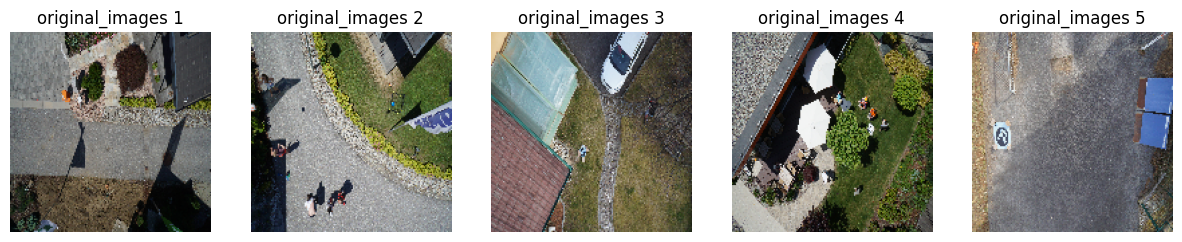

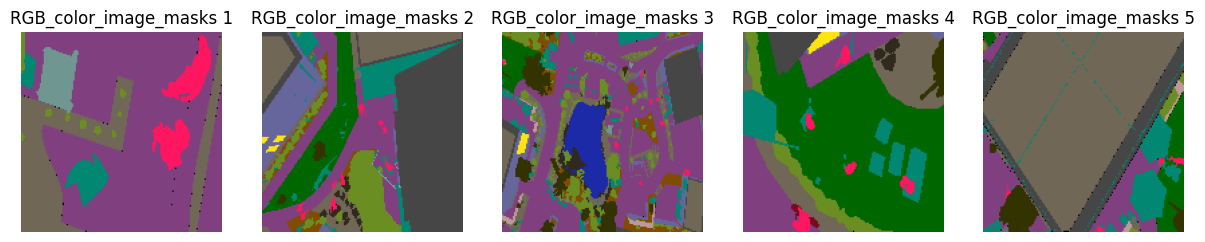

In [6]:
def display_images_by_class(parent_folder, n_images=5):
    class_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

    for class_folder in class_folders:
        class_path = os.path.join(parent_folder, class_folder)
        images = os.listdir(class_path)[:n_images]
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(images):
            img = load_img(os.path.join(class_path, img_name), target_size=(150, 150))
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"{class_folder} {i+1}")
            plt.axis('off')
        plt.show()

parent_folder = 'dataset/semantic_drone_dataset'
mask_folder = 'RGB_color_image_masks'

display_images_by_class(parent_folder, n_images=5)
display_images_by_class(mask_folder, n_images=5)

# **Data Preparation**
----

**create a map from class name to color**

In [7]:
classes = pd.read_csv('class_dict_seg.csv')
print('Num of classes = ' , len(classes))
classes

Num of classes =  24


,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [8]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}
cls2rgb

{0: ['unlabeled', 0, 0, 0],
 1: ['paved-area', 128, 64, 128],
 2: ['dirt', 130, 76, 0],
 3: ['grass', 0, 102, 0],
 4: ['gravel', 112, 103, 87],
 5: ['water', 28, 42, 168],
 6: ['rocks', 48, 41, 30],
 7: ['pool', 0, 50, 89],
 8: ['vegetation', 107, 142, 35],
 9: ['roof', 70, 70, 70],
 10: ['wall', 102, 102, 156],
 11: ['window', 254, 228, 12],
 12: ['door', 254, 148, 12],
 13: ['fence', 190, 153, 153],
 14: ['fence-pole', 153, 153, 153],
 15: ['person', 255, 22, 96],
 16: ['dog', 102, 51, 0],
 17: ['car', 9, 143, 150],
 18: ['bicycle', 119, 11, 32],
 19: ['tree', 51, 51, 0],
 20: ['bald-tree', 190, 250, 190],
 21: ['ar-marker', 112, 150, 146],
 22: ['obstacle', 2, 135, 115],
 23: ['conflicting', 255, 0, 0]}

# **Masks labels adjustment**
----

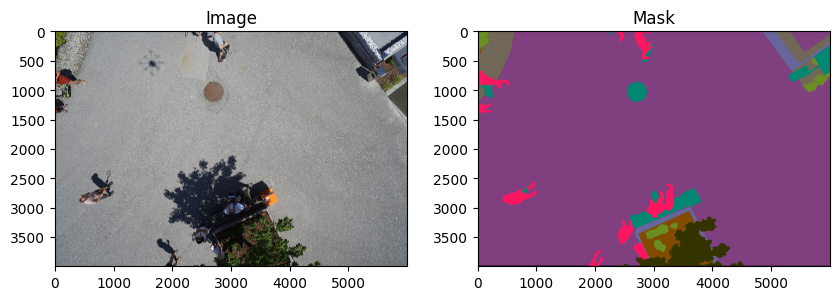

In [9]:
img = load_img('dataset/semantic_drone_dataset/original_images/000.jpg')
mask = load_img('RGB_color_image_masks/RGB_color_image_masks/000.png')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [10]:
mask = np.array(mask)
mask.shape

(4000, 6000, 3)

In [11]:
def adjust_mask(mask, flat=False):
    semantic_map = []
    for value in cls2rgb.values():
        # Extract only the RGB values (e.g., [64, 128, 64])
        colour = value[1:]  # Skip the class name
        colour_array = np.array(colour, dtype=np.uint8)  # Convert to uint8 array
        equality = np.equal(mask, colour_array)  # Compare mask with colour
        class_map = np.all(equality, axis=-1)  # 256x256 If all True, then True, else False
        semantic_map.append(class_map)  # Append 256x256 array

    semantic_map = np.stack(semantic_map, axis=-1)  # 256x256xN (N is the number of classes)

    if flat:
        semantic_map = np.reshape(semantic_map, (-1, 256*256))

    return np.float32(semantic_map)  # Convert to float32


In [12]:
new_mask = adjust_mask(mask)
new_mask.shape

(4000, 6000, 24)

Map the idx back to rgb to make sure everything is correct

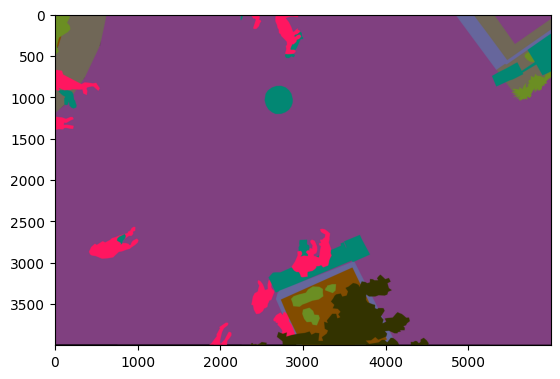

In [13]:
idx2rgb={idx:np.array(rgb[1:], dtype=np.uint8) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
# Only store RGB values as uint8 in idx2rgb

def map_class_to_rgb(p):
  return idx2rgb[p[0]]

rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))
plt.imshow(rgb_mask)
plt.show()

# **Load Data**
----

In [14]:
batch_sz = 4
n_classes = 24
data_path = 'dataset/semantic_drone_dataset'
mask_path = 'RGB_color_image_masks'
seed = 1
W = 768 
H = 512 

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation parameters for images and masks
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1./255)

mask_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

# Image and Mask Data Generators
image_datagen = ImageDataGenerator(**data_gen_args, validation_split=0.2)
mask_datagen  = ImageDataGenerator(**mask_gen_args, validation_split=0.2)

In [16]:
train_image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    target_size=(W, H),
    subset='training')

train_mask_generator = mask_datagen.flow_from_directory(
    mask_path,
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(W, H),
    subset='training')

train_generator = zip(train_image_generator, train_mask_generator)

def train_generator_fn():
    for (img, mask) in train_generator:
        new_mask = adjust_mask(mask)
        yield (img, new_mask)

Found 320 images belonging to 1 classes.
Found 320 images belonging to 1 classes.


In [17]:
val_image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    target_size=(W, H),
    subset='validation')

val_mask_generator = mask_datagen.flow_from_directory(
    mask_path,
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(W, H),
    subset='validation')

val_generator = zip(val_image_generator, val_mask_generator)

def val_generator_fn():
    for img, mask in val_generator:
        new_mask = adjust_mask(mask)
        yield img, new_mask

Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


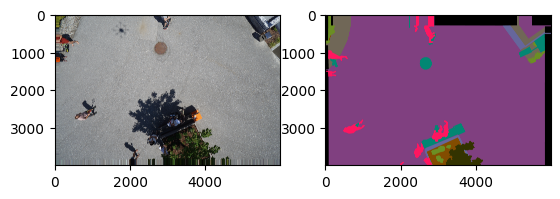

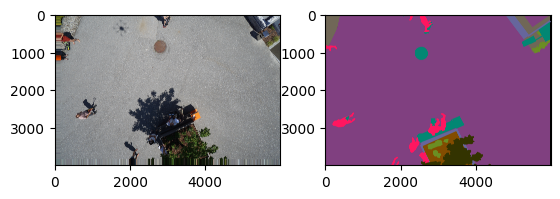

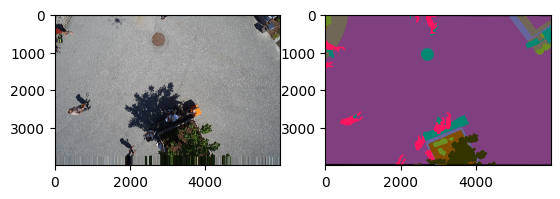

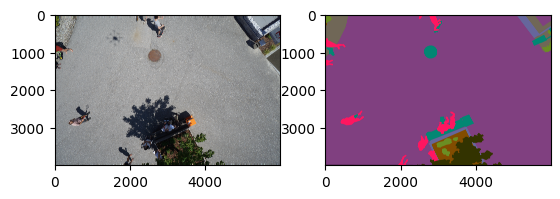

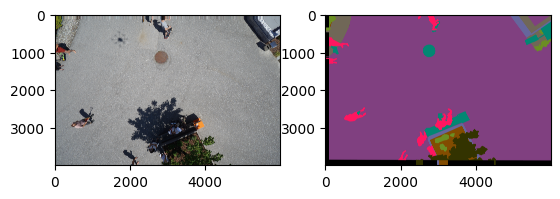

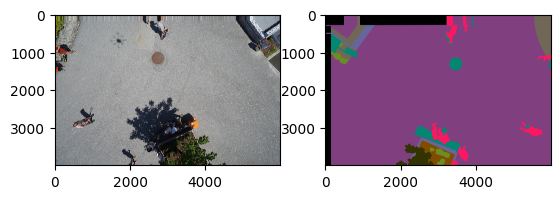

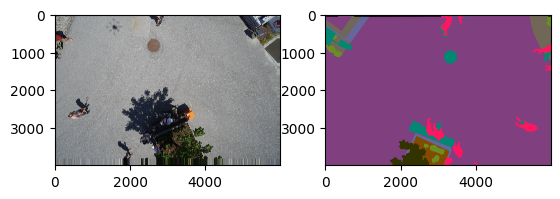

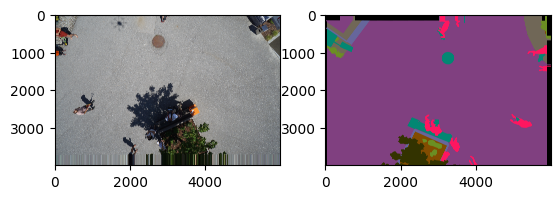

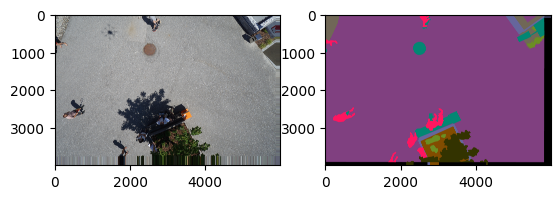

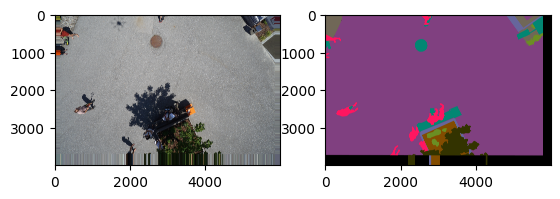

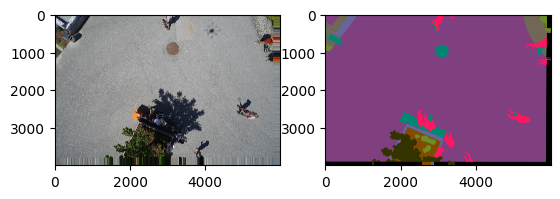

In [18]:
from keras.preprocessing.image import array_to_img, img_to_array
i = 0
img = img_to_array(img)
mask = img_to_array(mask)
for aug_img, aug_mask in zip(image_datagen.flow(np.expand_dims(img, 0), batch_size=1), mask_datagen.flow(np.expand_dims(mask, 0), batch_size=1)):
    plt.figure(i)
    plt.subplot(221)
    imgplot = plt.imshow(array_to_img(aug_img[0]))
    plt.subplot(222)
    imgplot = plt.imshow(array_to_img(aug_mask[0]))
    i += 1
    if i > 10:
        break

plt.show()

In [19]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y
def Unet(h, w, filters, num_classes = 24):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

# **Modeling**
----

In [20]:
model = Unet(W , H , 32)
model.summary()

Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 768, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 768, 512,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 768, 512,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 768, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 768, 512,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 768, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 384, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 384, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 384, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 384, 256,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 256,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 384, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 192, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 192, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 128,  │        512 │ conv2d_4[0][0]  

 Total params: 8,643,032 (32.97 MB)

 Trainable params: 8,637,144 (32.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [21]:
ES = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
history = model.fit(train_generator_fn(),
                    validation_data=val_generator_fn(),
                    steps_per_epoch=len(train_image_generator),
                    validation_steps=len(val_image_generator),
                    epochs=30,
                    batch_size=4,
                    callbacks=[ES,RL])

Epoch 1/30


I0000 00:00:1725076370.771675     109 service.cc:145] XLA service 0x7c62f00033a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725076370.771760     109 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725076403.182203     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.3984 - loss: 2.3153 - val_accuracy: 0.4861 - val_loss: 2.0217 - learning_rate: 0.0010
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 388s 5s/step - accuracy: 0.5738 - loss: 1.5144 - val_accuracy: 0.4825 - val_loss: 1.8776 - learning_rate: 0.0010
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 372s 5s/step - accuracy: 0.5704 - loss: 1.4679 - val_accuracy: 0.5035 - val_loss: 1.7337 - learning_rate: 0.0010
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 356s 5s/step - accuracy: 0.5792 - loss: 1.4319 - val_accuracy: 0.5012 - val_loss: 1.7481 - learning_rate: 0.0010
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0.5375 - loss: 1.5625 - val_accuracy: 0.5340 - val_loss: 1.5720 - learning_rate: 0.0010
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.5808 - loss: 1.4080 - val_accuracy: 0.5635 - val_loss: 1.4627 - learning_rate: 0.0010
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 356s 5s/step - accuracy: 0.5941 - loss: 1.3941 - val_accuracy: 0.54

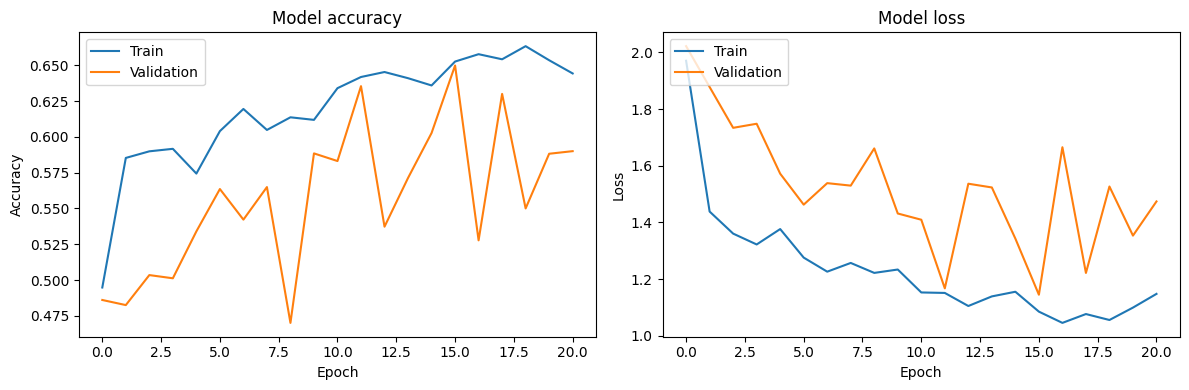

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# **Prediction**
----

In [24]:
loss, acc = model.evaluate(train_generator_fn(), steps=100, batch_size=128, verbose=0)
print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss, acc = model.evaluate(val_generator_fn(), steps=100, batch_size=128, verbose=0)
print('The accuracy of the model for test data is:',acc*100)
print('The Loss of the model for test data is:',loss)

The accuracy of the model for training data is: 68.30165386199951
The Loss of the model for training data is: 0.9505749344825745
The accuracy of the model for test data is: 67.56247878074646
The Loss of the model for test data is: 0.9947673678398132


**Display Some Images With Predictions**

In [25]:
def visualize_seg(img, gt_mask, shape='normal', gt_mode='sparse'):
  plt.figure(figsize=(12, 8))

  # Img
  plt.subplot(311)
  plt.imshow(img)
  plt.title('Original Image')
  plt.axis('off')

  # Predict
  pred_mask = model.predict(np.expand_dims(img, 0))
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[0]
  if shape=='flat':
    pred_mask = np.reshape(pred_mask, (256,256)) # Reshape only if you use the flat model. O.w. you dont need

  rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))

  # Prediction
  plt.subplot(312)
  plt.imshow(rgb_mask)
  plt.title('Predicted Mask')
  plt.axis('off')

  # GT mask
  if gt_mode == 'ohe':
    gt_img_ohe = np.argmax(gt_mask, axis=-1)
    gt_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(gt_img_ohe, -1))

  plt.subplot(313)
  plt.imshow((gt_mask).astype(np.uint8))
  plt.title('Ground Truth Mask')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


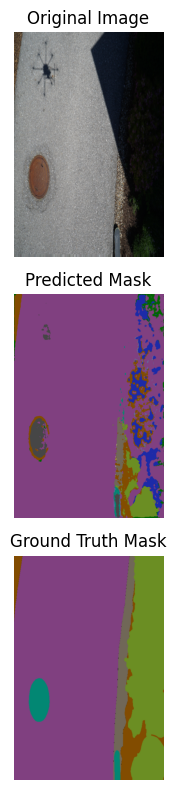

In [26]:
img = next(train_image_generator)[0]
gt_img = next(train_mask_generator)[0]
visualize_seg(img, gt_img, gt_mode='sparse')